<a href="https://colab.research.google.com/github/leokan92/class/blob/main/Aula2_redes_convolucionais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 2 - Redes Neurais Convolucionais: Exemplo simples

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## Configurações

In [4]:
# Configuração
BATCH_SIZE = 64
EPOCHS = 10
LR = 0.001

## Carregando Dataset MNIST

In [5]:
# Carregar o MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 60970035.73it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 45166179.65it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27173892.05it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12880682.06it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Arquitetura CNN

In [6]:
# Definir a CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return nn.LogSoftmax(dim=1)(x)

## Arquitetura totalmente conectada MLP



In [7]:
# Definir o MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        return nn.LogSoftmax(dim=1)(self.fc3(x))

In [8]:
# Função de treino
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Função de teste
def test(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 1 - correct / total  # Erro

In [9]:
# Treinando e Testando a CNN
cnn = CNN()
cnn_optimizer = optim.Adam(cnn.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
cnn_train_loss = []
cnn_test_error = []
for epoch in range(EPOCHS):
    train_loss = train(cnn, train_loader, cnn_optimizer, criterion)
    test_error = test(cnn, test_loader, criterion)
    cnn_train_loss.append(train_loss)
    cnn_test_error.append(test_error)
    print(f"CNN - Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Test Error: {test_error:.4f}")

# Treinando e Testando o MLP
mlp = MLP()
mlp_optimizer = optim.Adam(mlp.parameters(), lr=LR)
mlp_train_loss = []
mlp_test_error = []
for epoch in range(EPOCHS):
    train_loss = train(mlp, train_loader, mlp_optimizer, criterion)
    test_error = test(mlp, test_loader, criterion)
    mlp_train_loss.append(train_loss)
    mlp_test_error.append(test_error)
    print(f"MLP - Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Test Error: {test_error:.4f}")

# Comparando os resultados
print("\nComparação:")
print("CNN - Média Train Loss:", sum(cnn_train_loss)/EPOCHS, "Média Test Error:", sum(cnn_test_error)/EPOCHS)
print("MLP - Média Train Loss:", sum(mlp_train_loss)/EPOCHS, "Média Test Error:", sum(mlp_test_error)/EPOCHS)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


CNN - Epoch 1/10, Train Loss: 0.2144, Test Error: 0.0153
CNN - Epoch 2/10, Train Loss: 0.0920, Test Error: 0.0125
CNN - Epoch 3/10, Train Loss: 0.0700, Test Error: 0.0118
CNN - Epoch 4/10, Train Loss: 0.0592, Test Error: 0.0106
CNN - Epoch 5/10, Train Loss: 0.0510, Test Error: 0.0095
CNN - Epoch 6/10, Train Loss: 0.0425, Test Error: 0.0089
CNN - Epoch 7/10, Train Loss: 0.0369, Test Error: 0.0086
CNN - Epoch 8/10, Train Loss: 0.0356, Test Error: 0.0083
CNN - Epoch 9/10, Train Loss: 0.0309, Test Error: 0.0082
CNN - Epoch 10/10, Train Loss: 0.0291, Test Error: 0.0080
MLP - Epoch 1/10, Train Loss: 0.3005, Test Error: 0.0490
MLP - Epoch 2/10, Train Loss: 0.1399, Test Error: 0.0376
MLP - Epoch 3/10, Train Loss: 0.0998, Test Error: 0.0319
MLP - Epoch 4/10, Train Loss: 0.0814, Test Error: 0.0290
MLP - Epoch 5/10, Train Loss: 0.0653, Test Error: 0.0283
MLP - Epoch 6/10, Train Loss: 0.0610, Test Error: 0.0244
MLP - Epoch 7/10, Train Loss: 0.0518, Test Error: 0.0254
MLP - Epoch 8/10, Train Loss: 

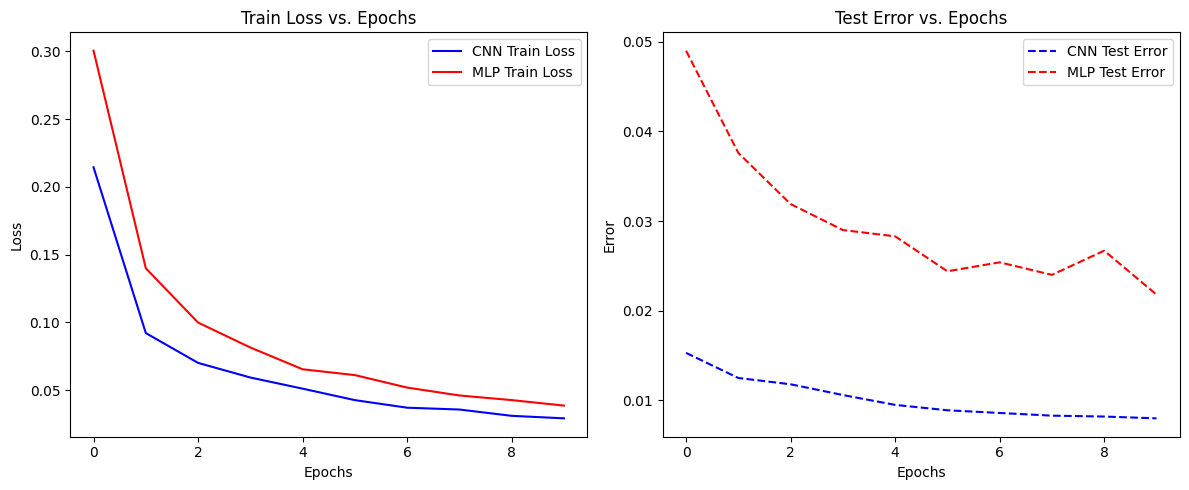

In [10]:
import matplotlib.pyplot as plt

# Plotando as curvas de treino
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, subplot 1
plt.plot(cnn_train_loss, label='CNN Train Loss', color='blue')
plt.plot(mlp_train_loss, label='MLP Train Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Epochs')
plt.legend()

# Plotando as curvas de teste
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, subplot 2
plt.plot(cnn_test_error, label='CNN Test Error', color='blue', linestyle='dashed')
plt.plot(mlp_test_error, label='MLP Test Error', color='red', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Test Error vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()
